In [4]:
!pip install tqdm

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
#import modules

#dataframe
import pandas as pd
#number processing
import numpy as np
#standard scaling
from sklearn.preprocessing import StandardScaler
#plotting
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

from tqdm import tqdm

#heatmap
import seaborn as sns

#math
import math

%matplotlib inline
import numpy as np
import scipy.spatial.distance as distance
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from random import random
from pandas import DataFrame, Series

import csv

In [2]:
#マウスリストの作成、神経データが記録されている全フェーズリストの作成
mouse_17list=["ID170704C","ID170704E","ID170704F","ID170704G"]
mouse_13list = ["ID138464-1","ID138464-2","ID138464-3","ID138464-4","ID138464-5","ID138464-6"]
mouse_list=mouse_13list+mouse_17list
phaseall_list=["HC1","B1","B2","HC2","A1","A2","A31","A32","A41","A42","HC3","A5","B3","A6","HC4","A7","B4"]
phase_Ablist=["A1","A2","A31","A32","A41","A42","A5","A6","A7"]
phase_Alist=["A1","A20","A21","A22","A23","A31","A32","A41","A42","A5","A60","A61","A62","A63","A7"]
phase_Blist=["B1","B2","B3","B4"]
phase_Hlist=["HC1","HC2","HC3","HC4"]
phase_ABlist=phase_Ablist+phase_Blist
phase_shocklist=["A2","A6"]
phase_shockdivlist=[0,1,2,3]
phase_daydivlist=[0,3,10,14,17]
category_list=["A","B","HC"]
phase_list=[phase_Ablist,phase_Blist,phase_Hlist]

/Users/rentakakura/anaconda/envs/jupyter-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
100%|██████████| 100/100 [00:00<00:00, 265.67it/s]


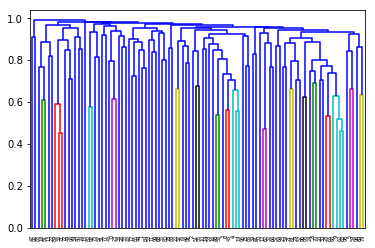

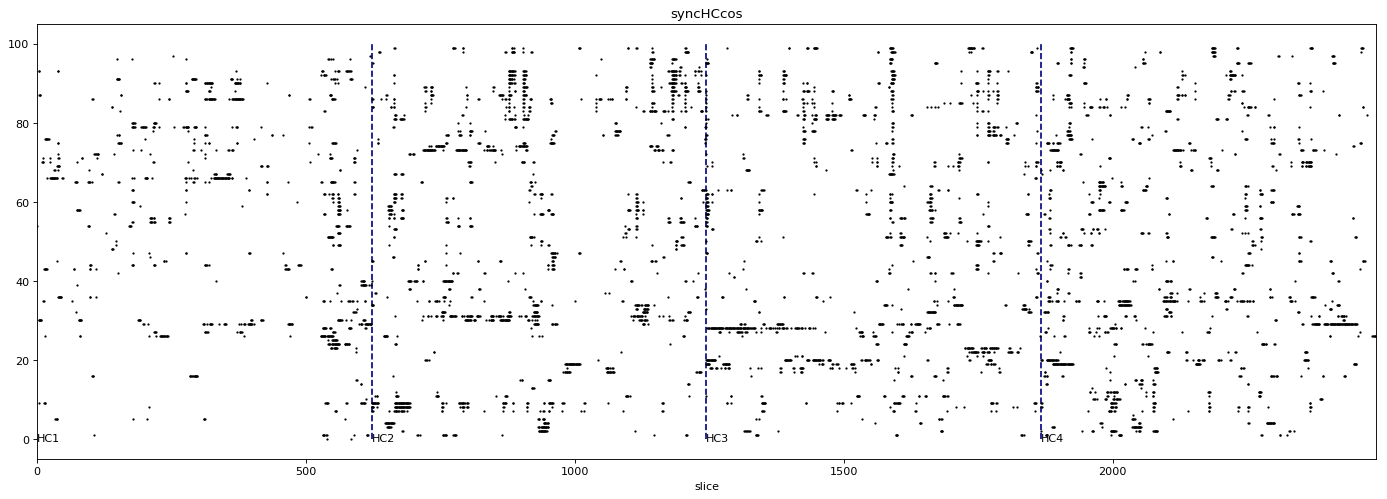

In [3]:
#分析実行

m=0

#category_list=["A","B","HC"]
c=0

mouse = mouse_list[m]
category=categiry_list[c]

#神経データをデータフレームにインポートする
inputf='%s/python/%s_Longitudinal_Traces.csv' %(mouse,mouse)
dff=pd.read_csv(inputf,header=0)
dff0=pd.DataFrame()

#Acceptのみを抽出したデータフレームの作成
dff0=dff.iloc[0,:]
Accept=dff0.index[dff0==' accepted']
dfa=pd.DataFrame()
dfa['Time2']=dff.iloc[1:,0]
for accept_c in range (0,len(Accept)):
    dfa[Accept[accept_c]]=dff[Accept[accept_c]].iloc[1:]
    dfa=dfa.astype('float')

#Acceptcellのfirst cellとlast cellを抽出
cell_f=dfa.columns[1]
cell_l=dfa.columns[dfa.shape[1]-1]

#phaseごと
#発火タイミングを点で表示:Async_ts(X:time(slice),Y:cell id)
#各cellにおいて、同期率が高い(同スライスで発火している確率が高い)順に並べている

inputf='%s/python/%s_mean_std_%sall.csv' %(mouse,mouse,category)          
dfmeanstd=pd.read_csv(inputf,header=0)

ts=2

dfmeanstd_sign=pd.DataFrame(index=dfmeanstd.index,columns=dfmeanstd.columns[:dfmeanstd.columns.get_loc(cell_l)+1])
dfmeanstd_sign.iloc[:,0:dfmeanstd_sign.columns.get_loc(cell_f)]=dfmeanstd.iloc[:,0:dfmeanstd.columns.get_loc(cell_f)]
dfmeanstd_sign.iloc[:,dfmeanstd_sign.columns.get_loc(cell_f):dfmeanstd_sign.columns.get_loc(cell_l)+1]=(np.sign(dfmeanstd.iloc[:,dfmeanstd.columns.get_loc(cell_f):dfmeanstd.columns.get_loc(cell_l)+1]-ts)+1)/2


dfmeanstd_sign_corr=pd.DataFrame(index=dfmeanstd_sign.columns[dfmeanstd_sign.columns.get_loc(cell_f):],columns=dfmeanstd_sign.columns[dfmeanstd_sign.columns.get_loc(cell_f):])

for i in range (dfmeanstd_sign_corr.shape[0]):
    for j in range(dfmeanstd_sign_corr.shape[1]):

        cell_left=dfmeanstd_sign_corr.index[i]
        cell_right=dfmeanstd_sign_corr.index[j]

        df_cell_left=dfmeanstd_sign[cell_left]
        df_cell_right=dfmeanstd_sign[cell_right]

        if(len(df_cell_left[df_cell_left==1])>0 and len(df_cell_right[df_cell_right==1])>0):

            dfmeanstd_sign_corr.iloc[i,j]=round(1.0-np.dot(df_cell_left,df_cell_right)/(np.linalg.norm(df_cell_left, ord=2)*np.linalg.norm(df_cell_right, ord=2)),5)
        else:

            dfmeanstd_sign_corr.iloc[i,j]=1.0

outputf='%s/python/%s_meanstdsigncorr_cos_%s.csv' %(mouse,mouse,category)
dfmeanstd_sign_corr.to_csv(outputf,index=False)

sign_corr_array=distance.squareform(dfmeanstd_sign_corr)

#クラスタリング
result = linkage(sign_corr_array, method = 'average')

leaves=dendrogram(result)['leaves']

outputf='%s/python/%s_meanstdleaves_cos_HC.csv' %(mouse,category)
with open(outputf, 'w') as file:
    writer = csv.writer(file, lineterminator='\n')
    writer.writerow(leaves)

In [ ]:
#分析実行

for m in range(len(mouse_list)):
    
    mouse = mouse_list[m]
    
    for p_c in range(len(cateogry_list)):
        
        plot_cateogry = category_list[p_c]
        
        phase_plotlist=phase_list[p_c]
        
        for o_c in range(len(order_list)):
            
            order_category = category_list[o_c]
    
            inputf='%s/python/%s_mean_std_%sall.csv' %(mouse,mouse,plot_category)          
            dfmeanstd=pd.read_csv(inputf,header=0)

            ts=2

            inputf='%s/python/%s_meanstdsigncorr_cos_%s.csv' %(mouse,mouse,order_category)
            dfmeanstd_sign_corr=pd.read_csv(inputf,header=0)

            inputf='%s/python/%s_meanstdleaves_cos_%s.csv' %(mouse,mouse,order_category)

            leaves=pd.read_csv(inputf,header=None)

            plt.figure(figsize=(5.4*4, 3.6*leaves.shape[1]/50), dpi=80)
            for cell_num in tqdm(range(leaves.shape[1])):

                df_plot=dfmeanstd[dfmeanstd_sign_corr.columns[leaves[cell_num]]]

                df_plot_ts=df_plot[df_plot[dfmeanstd_sign_corr.columns[leaves[cell_num]][0]]>2]

                plt.scatter(df_plot_ts.index,np.array([cell_num]*df_plot_ts.shape[0]),color='black',s=1,zorder=3)

            for k in range(dfmeanstd.shape[0]):

                if dfmeanstd.iloc[k].loc['FZ'] == 1:
                    if dfmeanstd.iloc[k].loc['X']  <= 125:
                        if dfmeanstd.iloc[k].loc['Y']  <=100:
                            Color='lightpink'
                        else:
                            Color='lightblue'
                    else:
                        if dfmeanstd.iloc[k].loc['Y']  <=100:
                            Color='silver'
                        else:
                            Color='lightgreen'
                    plt.fill([k,k+1,k+1,k],[0,0,dfmeanstd_sign_corr.shape[0],dfmeanstd_sign_corr.shape[0]],color=Color,zorder=1)
                if (dfmeanstd.iloc[k].loc['Shock'] == 1):
                    plt.plot([k,k],[0,dfmeanstd_sign_corr.shape[0]],color='red',linestyle='dashed',zorder=2)

                if k==0:

                    plt.annotate(phase_plotlist[0], (0,-0.5),size=10)

                    phase_cnt=0

                elif (dfmeanstd.iloc[k].loc['Time2']-dfmeanstd.iloc[k-1].loc['Time2'])>1.0:

                    phase_cnt=phase_cnt+1

                    plt.annotate(phase_plotlist[phase_cnt],(k,-0.5),size=10)

                    plt.plot([k,k],[0,dfmeanstd_sign_corr.shape[0]],color='navy',linestyle='dashed',zorder=2)

            title_name='sync%sby%scos'%(plot_category,order_category)
            file_name='%s/python/%s_figure/'%(mouse,mouse)+title_name+'.png'
            plt.title(title_name)
            plt.xlabel('slice')
            plt.xlim(0,dfmeanstd.shape[0])
            plt.savefig(file_name)
            plt.show()

In [ ]:
#分析実行

for m in range(len(mouse_list)):

    mouse = mouse_list[m]
    
    #phaseごと
    #発火タイミングを点で表示:Async_ts(X:time(slice),Y:cell id)
    #各cellにおいて、同期率が高い(同スライスで発火している確率が高い)順に並べている
       
    inputf='%s/python/%s_mean_std_HCall.csv' %(mouse,mouse)          
    dfmeanstd=pd.read_csv(inputf,header=0)
    
    ts=2
    
    inputf='%s/python/%s_meanstdsigncorr_B.csv' %(mouse,mouse)
    dfmeanstd_sign_corr=pd.read_csv(inputf,header=0)
    
    inputf='%s/python/%s_meanstdleaves_B.csv' %(mouse,mouse)    
    leaves=pd.read_csv(inputf,header=None)

    plt.figure(figsize=(5.4*4, 3.6*leaves.shape[1]/50), dpi=80)
    for cell_num in tqdm(range(leaves.shape[1])):

        df_plot=dfmeanstd[dfmeanstd_sign_corr.columns[leaves[cell_num]]]
        
        df_plot_ts=df_plot[df_plot[dfmeanstd_sign_corr.columns[leaves[cell_num]][0]]>2]
        
        plt.scatter(df_plot_ts.index,np.array([cell_num]*df_plot_ts.shape[0]),color='black',s=1,zorder=3)

    for k in range(dfmeanstd.shape[0]):
        
        if k==0:

            plt.annotate('HC1', (0,-0.5),size=10)

            phase_cnt=0

        elif (dfmeanstd.iloc[k].loc['Time2']-dfmeanstd.iloc[k-1].loc['Time2'])>1.0:

            phase_cnt=phase_cnt+1

            plt.annotate(phase_Hlist[phase_cnt],(k,-0.5),size=10)

            plt.plot([k,k],[0,dfmeanstd_sign_corr.shape[0]],color='navy',linestyle='dashed',zorder=2)        
        
    title_name='syncHCbyBall'
    file_name='%s/python/%s_figure/'%(mouse,mouse)+title_name+'.png'
    plt.title(title_name)
    plt.xlabel('slice')
    plt.xlim(0,dfmeanstd.shape[0])
    plt.savefig(file_name)
    plt.show()

In [ ]:
#分析実行

for m in range(len(mouse_list)):

    mouse = mouse_list[m]
    
    #phaseごと
    #発火タイミングを点で表示:Async_ts(X:time(slice),Y:cell id)
    #各cellにおいて、同期率が高い(同スライスで発火している確率が高い)順に並べている
       
    inputf='%s/python/%s_mean_std_Aall.csv' %(mouse,mouse)          
    dfmeanstd=pd.read_csv(inputf,header=0)
    
    ts=2
    
    inputf='%s/python/%s_meanstdsigncorr_B.csv' %(mouse,mouse)
    dfmeanstd_sign_corr=pd.read_csv(inputf,header=0)
    
    inputf='%s/python/%s_meanstdleaves_B.csv' %(mouse,mouse)    
    leaves=pd.read_csv(inputf,header=None)

    plt.figure(figsize=(5.4*4, 3.6*leaves.shape[1]/50), dpi=80)
    for cell_num in tqdm(range(leaves.shape[1])):

        df_plot=dfmeanstd[dfmeanstd_sign_corr.columns[leaves[cell_num]]]
        
        df_plot_ts=df_plot[df_plot[dfmeanstd_sign_corr.columns[leaves[cell_num]][0]]>2]
        
        plt.scatter(df_plot_ts.index,np.array([cell_num]*df_plot_ts.shape[0]),color='black',s=1,zorder=3)

    for k in range(dfmeanstd.shape[0]):

        if dfmeanstd.iloc[k].loc['FZ'] == 1:
            if dfmeanstd.iloc[k].loc['X']  <= 125:
                if dfmeanstd.iloc[k].loc['Y']  <=100:
                    Color='lightpink'
                else:
                    Color='lightblue'
            else:
                if dfmeanstd.iloc[k].loc['Y']  <=100:
                    Color='silver'
                else:
                    Color='lightgreen'
            plt.fill([k,k+1,k+1,k],[0,0,dfmeanstd_sign_corr.shape[0],dfmeanstd_sign_corr.shape[0]],color=Color,zorder=1)
        if (dfmeanstd.iloc[k].loc['Shock'] == 1):
            plt.plot([k,k],[0,dfmeanstd_sign_corr.shape[0]],color='red',linestyle='dashed',zorder=2)

        if k==0:

            plt.annotate('A1', (0,-0.5),size=10)

            phase_cnt=0

        elif (dfmeanstd.iloc[k].loc['Time2']-dfmeanstd.iloc[k-1].loc['Time2'])>1.0:

            phase_cnt=phase_cnt+1

            plt.annotate(phase_Alist[phase_cnt],(k,-0.5),size=10)

            plt.plot([k,k],[0,dfmeanstd_sign_corr.shape[0]],color='navy',linestyle='dashed',zorder=2)

    title_name='syncAbyBall'
    file_name='%s/python/%s_figure/'%(mouse,mouse)+title_name+'.png'
    plt.title(title_name)
    plt.xlabel('slice')
    plt.xlim(0,dfmeanstd.shape[0])
    plt.savefig(file_name)
    plt.show()

In [ ]:
df_plot[df_plot>2]

In [ ]:
dfmeanstd_sign_corr[' C053']

In [ ]:
dfmeanstd[' C053']

In [ ]:
dfmeanstd_sign_corr.loc[' C053',:]

In [ ]:
dfmeanstd_sign_corr.loc[:,' C053']

In [ ]:
dfmeanstd[' C053']

In [ ]:
dfmeanstd_sign_corr[dfmeanstd_sign_corr.isnull()==False].count().sum()

In [ ]:
df_cell_left=dfmeanstd_sign[' C053']

In [ ]:
df_cell_left[df_cell_left==0]

In [ ]:
dfmeanstd_sign_corr.columns[leaves[cell_num]]

In [12]:
phase_list=[[]]


In [17]:
phase_aalist[2][0]

'HC1'

In [16]:
phase_aalist=[phase_Ablist,phase_Blist,phase_Hlist]